In [114]:
# pytorch
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet

# other
from myutils import SSIM, PSNR
from mymodels import VisionTransformer, ReconNet
import os
# Device
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = 'cuda'

In [115]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"  {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
GPU count: 1
  0: NVIDIA L40S


In [116]:
class fastMRIDataset(Dataset):
    def __init__(self, challenge, path, isval):
        """
        Dataloader for 4x acceleration and random sampling
        challenge: 'multicoil' or 'singlecoil'
        path: path to dataset
        isval: whether dataset is fastMRI's validation set or training set
        """
        self.challenge = challenge 
        self.data_path = path
        self.isval = isval

        self.data = mri_data.SliceDataset(
            root=self.data_path,
            transform=self.data_transform,
            challenge=self.challenge,
            use_dataset_cache=True,
            )

        self.mask_func = subsample.RandomMaskFunc( # RandomMaskFunc for knee, EquispacedMaskFunc for brain
            center_fractions=[0.08],
            accelerations=[4],
            )
            
    def data_transform(self, kspace, mask, target, data_attributes, filename, slice_num):
        if self.isval:
            seed = tuple(map(ord, filename))
        else:
            seed = None     
        kspace = transforms.to_tensor(kspace)
        masked_kspace, *_ = transforms.apply_mask(kspace, self.mask_func, seed)        
        
        target = transforms.to_tensor(target)
        zero_fill = fastmri.ifft2c(masked_kspace)
        zero_fill = transforms.complex_center_crop(zero_fill, target.shape)   
        x = fastmri.complex_abs(zero_fill)
        
        if self.challenge == 'multicoil':
            x = fastmri.rss(x)

        x = x.unsqueeze(0)
        target = target.unsqueeze(0)
        
        return (x, target, data_attributes['max'])    

    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]

        return data
   

### Please specifiy data path here

In [117]:
challenge = 'singlecoil' # 'multicoil' or 'singlecoil'
train_path = '../data/singlecoil_train/' # path to fastmri's training data
val_path = '../data/singlecoil_val/' # path to fastmri's validation data
dataset = fastMRIDataset(challenge=challenge, path=train_path, isval=False)
val_dataset = fastMRIDataset(challenge=challenge, path=val_path, isval=True)

ntrain = len(dataset) # number of training data


#ntrain = 100 # RUNNING EXPERIMENT WITH 100



train_dataset, _ = torch.utils.data.random_split(dataset, [ntrain, len(dataset)-ntrain], generator=torch.Generator().manual_seed(42))
print(len(train_dataset))

34742


In [118]:
batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, generator=torch.Generator().manual_seed(42))
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)  

### Select model here

In [119]:
"""Init Model"""
## Vision Transformer
# avrg_img_size = 340
avrg_img_size = 320

patch_size = 10
depth = 10
num_heads = 16
embed_dim = 44

net = VisionTransformer(
    avrg_img_size=avrg_img_size, 
    patch_size=patch_size, 
    in_chans=1, embed_dim=embed_dim, 
    depth=depth, num_heads=num_heads,
    )

## Unet
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=32,
#     num_pool_layers=4,
#     )

model = ReconNet(net).to(device)


print('#Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

#Params: 60408228
ReconNet(
  (net): VisionTransformer(
    (patch_embed): Conv2d(1, 704, kernel_size=(10, 10), stride=(10, 10))
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-9): 10 x Block(
        (norm1): LayerNorm((704,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA(
          (qkv): Linear(in_features=704, out_features=2112, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=704, out_features=704, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((704,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=704, out_features=2816, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=2816, out_features=704, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((704,), eps=1e-05, el

In [120]:
# Validate model
def validate(model):
    valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)   
    model.eval()    
    ssim_ = SSIM().to(device)
    psnr_ = PSNR().to(device)
    psnrs = []
    ssims = []
    
    with torch.no_grad():
        for data in valloader:
            inputs, targets, maxval = data        
            outputs = model(inputs.to(device))
            ssims.append(ssim_(outputs, targets.to(device), maxval.to(device)))
            psnrs.append(psnr_(outputs, targets.to(device), maxval.to(device)))
    
    ssimval = torch.cat(ssims).mean()
    
    print(' Recon. PSNR: {:0.3f} pm {:0.2f}'.format(torch.cat(psnrs).mean(), 2*torch.cat(psnrs).std()))
    print(' Recon. SSIM: {:0.4f} pm {:0.3f}'.format(torch.cat(ssims).mean(), 2*torch.cat(ssims).std()))
                
    return (1-ssimval).item()

# Save model
def save_model(path, model, train_hist, val_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(), 
        }
    else:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        
    torch.save(train_hist, path + 'train_hist.pt')
    torch.save(val_hist, path + 'val_hist.pt')    
    torch.save(checkpoint,  path + 'checkpoint.pth')

In [125]:
"""Optimizer"""
criterion = SSIMLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
val_hist = []
best_val = float("inf")
path = './' # Path for saving model checkpoint and loss history



num_epochs = 6



scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005,
                                          total_steps=num_epochs, pct_start=0.1,
                                          anneal_strategy='linear',
                                          cycle_momentum=False,
                                          base_momentum=0., max_momentum=0., div_factor=0.1*num_epochs, final_div_factor=9)

In [126]:
"""Train Model"""
val_every = 5  # ← only validate every `val_every` epochs

for epoch in range(0, num_epochs):
    print(f"\n🔁 Starting Epoch {epoch+1}/{num_epochs}...")
    model.train()
    train_loss = 0.0

    for batch_idx, data in enumerate(trainloader):
        inputs, targets, maxval = data
        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device), maxval.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1.)
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0 or batch_idx == len(trainloader) - 1:
            print(f"  Batch {batch_idx+1}/{len(trainloader)} - Loss: {loss.item():.4f}")

    if scheduler:
        scheduler.step()

    epoch_loss = train_loss / len(trainloader)
    train_hist.append(epoch_loss)
    print(f"✅ Epoch {epoch+1} completed. Avg Train Loss: {epoch_loss:.4f}")

    # Conditional Validation
    if (epoch + 1) % val_every == 0 or epoch == num_epochs - 1:
        print("🧪 Running Validation...")
        val_score = validate(model)
        val_hist.append(val_score)

        if val_score < best_val:
            print(f"💾 New best validation score: {val_score:.4f} (previous best: {best_val:.4f}). Saving model.")
            save_model(path, model, train_hist, val_hist, optimizer, scheduler=scheduler)
            best_val = val_score
        else:
            print(f"Validation score did not improve: {val_score:.4f} (best: {best_val:.4f})")
    else:
        print("⏭️ Skipping validation this epoch.")




🔁 Starting Epoch 1/6...
  Batch 1/4343 - Loss: 0.2540
  Batch 101/4343 - Loss: 0.3483
  Batch 201/4343 - Loss: 0.2546
  Batch 301/4343 - Loss: 0.3054
  Batch 401/4343 - Loss: 0.3318
  Batch 501/4343 - Loss: 0.3271
  Batch 601/4343 - Loss: 0.2462
  Batch 701/4343 - Loss: 0.3655
  Batch 801/4343 - Loss: 0.3312
  Batch 901/4343 - Loss: 0.3004
  Batch 1001/4343 - Loss: 0.2317
  Batch 1101/4343 - Loss: 0.2431
  Batch 1201/4343 - Loss: 0.2322
  Batch 1301/4343 - Loss: 0.3397
  Batch 1401/4343 - Loss: 0.2376
  Batch 1501/4343 - Loss: 0.3507
  Batch 1601/4343 - Loss: 0.2893
  Batch 1701/4343 - Loss: 0.2378
  Batch 1801/4343 - Loss: 0.2805
  Batch 1901/4343 - Loss: 0.3230
  Batch 2001/4343 - Loss: 0.3275
  Batch 2101/4343 - Loss: 0.2500
  Batch 2201/4343 - Loss: 0.2137
  Batch 2301/4343 - Loss: 0.2916
  Batch 2401/4343 - Loss: 0.2862
  Batch 2501/4343 - Loss: 0.2491
  Batch 2601/4343 - Loss: 0.3458
  Batch 2701/4343 - Loss: 0.2303
  Batch 2801/4343 - Loss: 0.2363
  Batch 2901/4343 - Loss: 0.29

Final Validation

In [ ]:
print("🧪 Running Validation...")
val_score = validate(model)
val_hist.append(val_score)

if val_score < best_val:
    print(f"💾 New best validation score: {val_score:.4f} (previous best: {best_val:.4f}). Saving model.")
    save_model(path, model, train_hist, val_hist, optimizer, scheduler=scheduler)
    best_val = val_score
else:
    print(f"Validation score did not improve: {val_score:.4f} (best: {best_val:.4f})")

Plotting

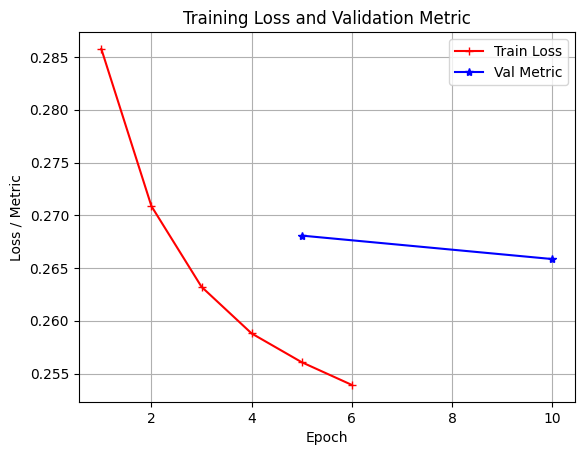

In [127]:
import matplotlib.pyplot as plt

"""Loss History Plot"""
plt.plot(range(1, len(train_hist) + 1), train_hist, 'r+-')

if len(val_hist) == len(train_hist):
    plt.plot(range(1, len(val_hist) + 1), val_hist, 'b*-')
else:
    plt.plot([i*5 for i in range(1, len(val_hist)+1)], val_hist, 'b*-')

plt.xlabel('Epoch')
plt.ylabel('Loss / Metric')
plt.grid(True)
plt.title('Training Loss and Validation Metric')
plt.legend(['Train Loss', 'Val Metric'])
plt.show()


1
 ssim: [0.63881111]
*ssim: [0.59706822]
 psnr: 28.598997204529866
*psnr: 28.272691313473363
 nmse: 0.07276375090886489
*nmse: 0.07844147394701129


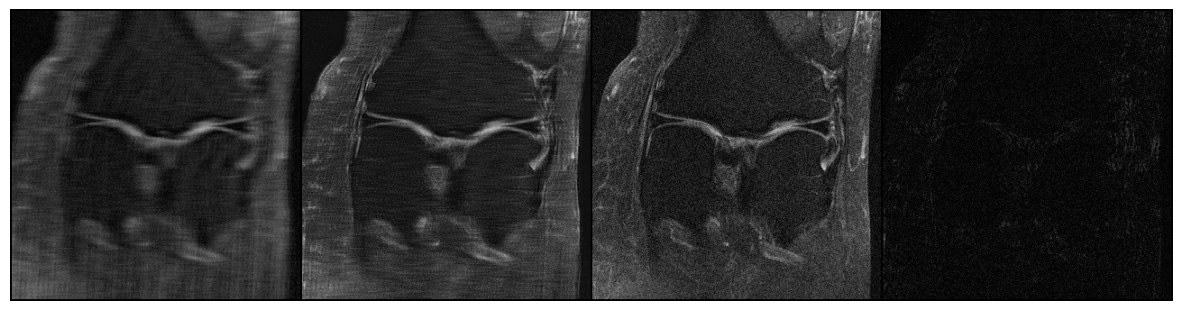

2
 ssim: [0.7752989]
*ssim: [0.67513442]
 psnr: 32.97718086131708
*psnr: 30.75153462794958
 nmse: 0.02970999079034658
*nmse: 0.04959832723871716


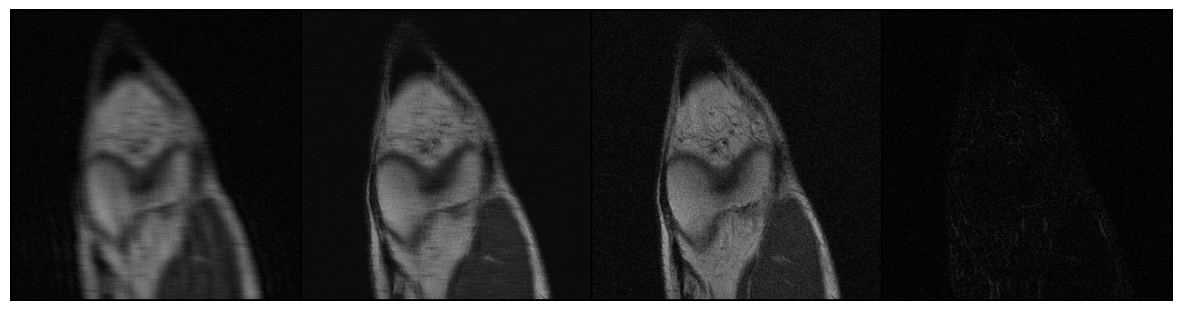

3
 ssim: [0.59361912]
*ssim: [0.54492674]
 psnr: 26.74662443672876
*psnr: 26.46278029119359
 nmse: 0.09002471360697036
*nmse: 0.0961050565405827


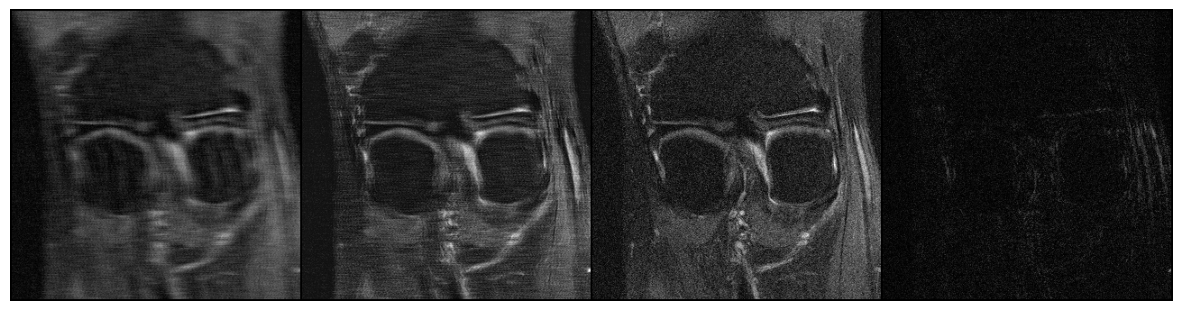

4
 ssim: [0.67449704]
*ssim: [0.57694795]
 psnr: 29.277071613085496
*psnr: 27.557901191159896
 nmse: 0.03618307415162383
*nmse: 0.05375546199334298


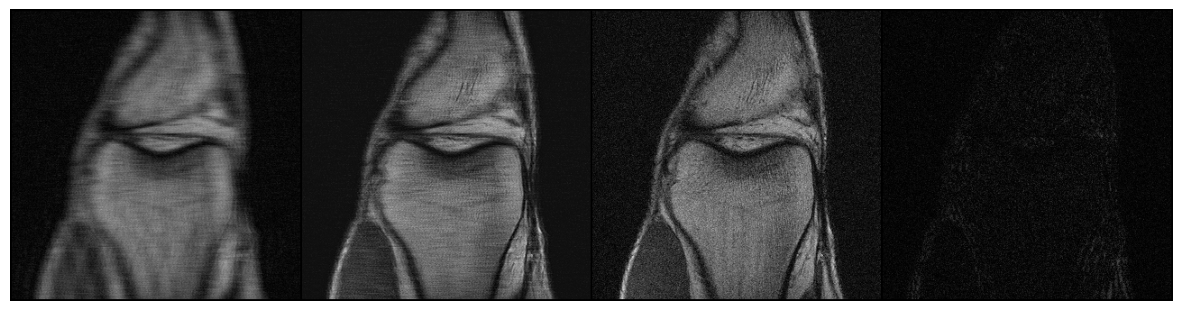

5
 ssim: [0.65462576]
*ssim: [0.60206288]
 psnr: 28.609412617731373
*psnr: 27.969652625456295
 nmse: 0.023900676243170396
*nmse: 0.027694042388132282


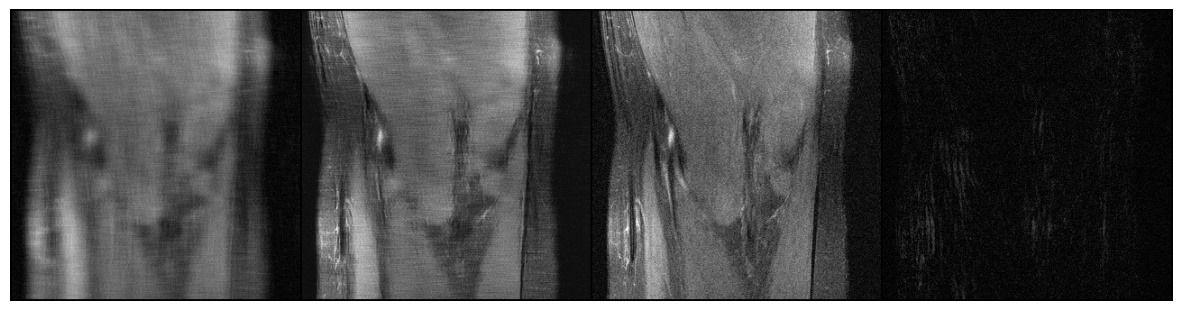

In [128]:
import matplotlib.pyplot as plt
from myutils import imshow

"""Example reconstructions"""
valloader = DataLoader(val_dataset, batch_size=8, pin_memory=True, shuffle=True, num_workers=12, generator=torch.Generator().manual_seed(0))
dataiter = iter(valloader)
model.eval()

with torch.no_grad():
    for k in range(0,5):    
        inputs, targets, maxval = next(dataiter)
        outputs = model(inputs.to(device)).cpu()
        plt.figure(figsize=(15,7))
        imshow(make_grid([inputs[0], outputs[0], targets[0], (targets[0]-outputs[0]).abs()],normalize = True, value_range=(0,maxval[0]/1.5)))
        plt.axis('off')
        img_input = inputs[0].numpy()
        img_recon = outputs[0].numpy()
        img = targets[0].numpy()
        print(k+1)
        print(' ssim:', ssim(img, img_recon, maxval[0].item()))
        print('*ssim:', ssim(img, img_input, maxval[0].item()))
        print(' psnr:', psnr(img, img_recon, maxval[0].item()))
        print('*psnr:', psnr(img, img_input, maxval[0].item()))
        print(' nmse:', nmse(img, img_recon, ))
        print('*nmse:', nmse(img, img_input))
        plt.show()

In [129]:
print(type(val_dataset.data))           # Should be Subset
#print(type(val_dataset.data.dataset))   # Should be SliceDataset



<class 'fastmri.data.mri_data.SliceDataset'>


Generate Ground Truth. vs. Generated Images

✅ Found: file1000073.h5, Slice 17, Index 338


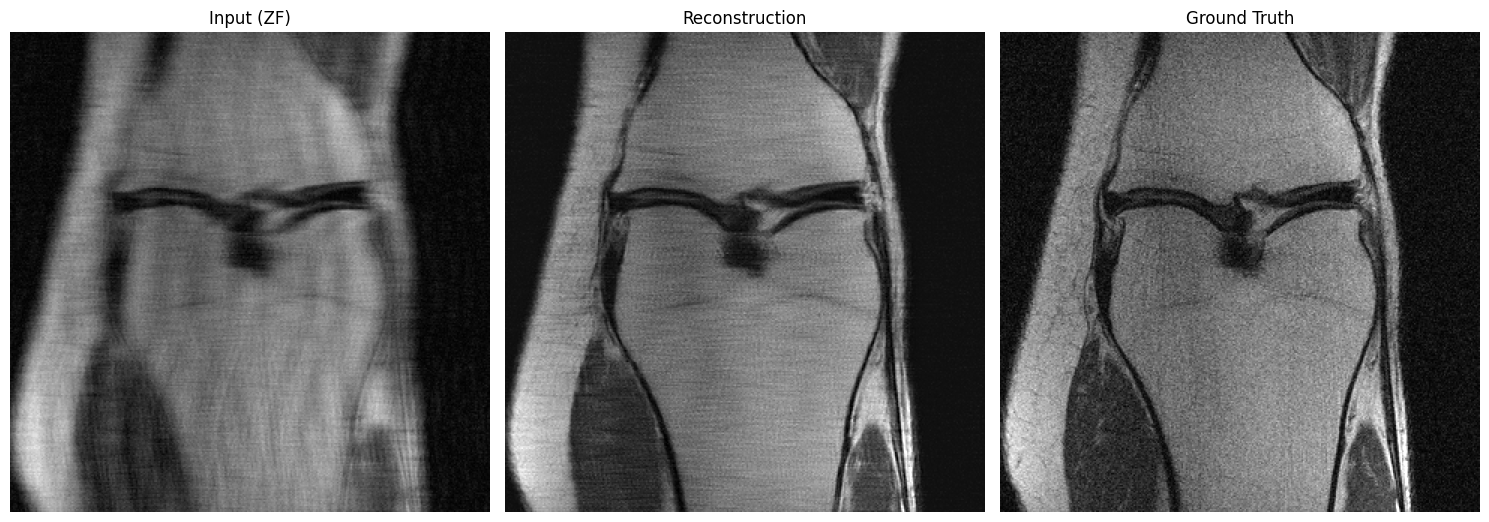

SSIM (Recon vs GT):  0.6708
SSIM (Input vs GT):  0.5661
PSNR (Recon vs GT):  28.50
PSNR (Input vs GT):  25.34
NMSE (Recon vs GT):  0.0202
NMSE (Input vs GT):  0.0419


In [130]:
import matplotlib.pyplot as plt
from myutils import imshow
from torchvision.utils import make_grid
import torch
from fastmri.data import mri_data

# 🔍 Use just the file name
filename_query = "file1000073.h5"
slice_index_query = 17

# Create a raw SliceDataset with NO transform
raw_val_data = mri_data.SliceDataset(
    root=val_dataset.data_path,
    challenge=val_dataset.challenge,
    transform=None
)

model.eval()
found = False

with torch.no_grad():
    for i in range(len(raw_val_data)):
        kspace, mask, target, attrs, fname, slice_idx = raw_val_data[i]

        if filename_query in fname and slice_idx == slice_index_query:
            print(f"✅ Found: {fname}, Slice {slice_idx}, Index {i}")
            x, y, maxval = val_dataset.data_transform(kspace, mask, target, attrs, fname, slice_idx)
            input_tensor = x.unsqueeze(0).to(device)
            output_tensor = model(input_tensor).cpu().squeeze(0)
            found = True
            break

if not found:
    print("❌ No match found.")
else:
    input_img = x.squeeze().cpu()
    recon_img = output_tensor.squeeze().cpu()
    target_img = y.squeeze().cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    for ax, img, title in zip(
        axes,
        [input_img, recon_img, target_img],
        ["Input (ZF)", "Reconstruction", "Ground Truth"]
    ):
        ax.imshow(img.numpy(), cmap='gray', vmin=0, vmax=maxval/1.5)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    gt = target_img.unsqueeze(0).numpy()
    recon = recon_img.unsqueeze(0).numpy()
    zf = input_img.unsqueeze(0).numpy()

    print(f"SSIM (Recon vs GT):  {ssim(gt, recon, maxval=maxval.item()).item():.4f}")
    print(f"SSIM (Input vs GT):  {ssim(gt, zf, maxval=maxval.item()).item():.4f}")
    print(f"PSNR (Recon vs GT):  {psnr(gt, recon, maxval=maxval.item()).item():.2f}")
    print(f"PSNR (Input vs GT):  {psnr(gt, zf, maxval=maxval.item()).item():.2f}")
    print(f"NMSE (Recon vs GT):  {nmse(gt, recon).item():.4f}")
    print(f"NMSE (Input vs GT):  {nmse(gt, zf).item():.4f}")

